Besu IBFT2.0 Log Data Analysis

In [1]:
import pandas as pd
import numpy as np
import warnings, os, json
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

def load_log(log_file: str):
    with open(log_file, 'r') as file:
        lines = [x.split(' | ') for x in file.read().splitlines() if 'IbftRound' in x]
        lines = [line for line in lines if len(line) > 1]
    result = {}
    for i in range(len(lines)):
        result[i] = lines[i]
    
    j = json.dumps(result)
    df = pd.read_json(j, orient='index')
    df.rename(columns={0: 'Timestamp',
                        1: 'Process',
                        2: 'LogLevel',
                        3: 'LogSource',
                        4: 'Description'}, inplace=True)

    df['Timestamp'] = pd.to_datetime(df.Timestamp, infer_datetime_format=True, utc=True)
    df_temp = df.loc[:, 'Description'].str.split('\. round=ConsensusRoundIdentifier', expand=True)
    df.loc[:, 'Action'] = df_temp[0].values
    df.loc[:, 'Order'] = df_temp[1].values
    df_des = df.Order.str.split('Sequence=', expand=True)[1].str.split('\, Round=', expand=True)
    df.loc[:, 'Sequence'] = df_des[0].astype(int)
    df.loc[:, 'Round'] = df_des[1].str.split('\}', expand=True)[0].astype(int)

    df.reset_index(inplace=True)
    df.drop(columns=['index', 'Description','Order'], axis=1, inplace=True)
    return df

def logs2df(logpath):
    files = [file for file in os.listdir(logpath) if 'besu' in file and '.log' in file]
    df_list = []
    for file in files:
        logfile = os.path.join(logpath, file)
        node_num = int(file.split('.')[0].split('-')[1])
        df = load_log(logfile)
        df['Node'] = node_num
        df_list.append(df)
    df = pd.concat(df_list)
    return df

def cal_time_delta(send: str, receive: str, df: pd.DataFrame) -> list:
    t_delta_ls = []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        if send in df_seq.Action.unique() and 'proposed' in send:
            c_time = pd.to_datetime(df_seq[df_seq.Action == send].Timestamp.values[0], utc=True)
            df_r = df_seq.loc[df_seq.Action == receive]
            for _, row in df_r.iterrows():
                t_delta = pd.to_datetime(row.Timestamp, utc=True) - c_time
                t_delta_ls.append(t_delta.total_seconds())
        else:
            df_send = df_seq.loc[df_seq.Action == send].sort_values('Timestamp')
            df_receive = df_seq.loc[df_seq.Action == receive].reset_index()
            sendNodes = len(df_send.Node.unique())
            receiveNodes = len(df_receive.Node.unique())
            if sendNodes == receiveNodes or sendNodes+1 == receiveNodes:
                ts = []
                for node in df_receive.Node.unique():
                    t = list(pd.to_datetime(df_receive.loc[df_receive.Node == node].Timestamp.values, utc=True))
                    ts.append(t)
                for _, row in df_send.iterrows():
                    sts = pd.to_datetime(row.Timestamp, utc=True)
                    for i in range(len(ts)):
                        if (row.Node != (i+1)) and ts[i]:
                            rts = ts[i].pop(0)
                            deltatime = (rts - sts).total_seconds()
                            t_delta_ls.append(deltatime)
    return t_delta_ls

def cal_process_time(df):
    t_process_proposal, t_process_prepare, t_process_commit = [], [], []
    sequences = df.Sequence.unique()
    for seq in sequences:
        df_seq = df.loc[df.Sequence == seq]
        for _, row in df_seq.iterrows():
            if row.Action == 'Received a proposal message':
                rts_prop = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending prepare message':
                sts_prep = pd.to_datetime(row.Timestamp, utc=True)
                t_process_proposal.append((sts_prep - rts_prop).total_seconds())
            if row.Action == 'Received a prepare message':
                rts_prep = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Sending commit message':
                sts_commit = pd.to_datetime(row.Timestamp, utc=True)
                t_process_prepare.append((sts_commit - rts_prep).total_seconds())
            if row.Action == 'Received a commit message':
                rts_commit = pd.to_datetime(row.Timestamp, utc=True)
                continue
            if row.Action == 'Importing block to chain':
                sts_import = pd.to_datetime(row.Timestamp, utc=True)
                t_process_commit.append((sts_import - rts_commit).total_seconds())
    return t_process_proposal, t_process_prepare, t_process_commit

def cal_consensus_time(df: pd.DataFrame) -> list:
    consensus_time = []
    for seq in df.Sequence.unique():
        df_seq = df.loc[(df.Sequence == seq) & ((df.Action.str.contains('block') | df.Action.str.contains('proposal')))].sort_values('Timestamp')
        ts = df_seq.Timestamp.values
        delta_t = pd.Timedelta(ts[-1] - ts[0]).total_seconds()
        consensus_time.append(delta_t)
    return consensus_time

def remove_outlier_IQR(ts):
    Q1=np.percentile(a=ts, q=25)
    Q3=np.percentile(a=ts, q=75)
    IQR = Q3 - Q1
    ts_final = [t for t in ts if t > Q1 - 1.5*IQR and t < Q3 + 1.5*IQR]
    return ts_final

def plot_hist(ts, ax=None, upper=None, bins=50, title='Frequency Histogram', xlabel='Time (ms)', ylabel='Frequency'):
    '''
    ts: time list in seconds
    upper(option): upper threshold in seconds
    bins: number of bins in histogram plot
    '''
    ax = ax or plt.gca()
    x = [1000*t for t in ts]
    if upper:
        x = [1000*t for t in ts if t>0 and t<upper]
    hist = ax.hist(x, bins=bins)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    return hist

In [ ]:
def cal_consensus_ts(df: pd.DataFrame) -> list:
    consensus_time = []
    for seq in df.Sequence.unique():
        df_seq = df.loc[(df.Sequence == seq) & ((df.Action.str.contains('block') | df.Action.str.contains('proposal')))].sort_values('Timestamp')
        ts = df_seq.Timestamp.values
        delta_t = pd.Timedelta(ts[-1] - ts[0]).total_seconds()
        consensus_time.append(delta_t)
    return consensus_time

In [3]:
logpaths = {'4nodes': '../data/logs-20220126-205727-cyb-4',
            '6nodes': '../data/logs-20220127-135037-cyb-6',
            '8nodes': '../data/logs-20220127-154811-cyb-8'}
df4 = logs2df(logpath=logpaths['4nodes'])
df6 = logs2df(logpath=logpaths['6nodes'])
df8 = logs2df(logpath=logpaths['8nodes'])

In [4]:
logpaths = {'5nodes': '../data/logs-20220207-123948-cyb-5'}
df5 = logs2df(logpath=logpaths['5nodes'])

In [4]:
send_str, receive_str = 'Creating proposed block', 'Received a proposal message'
ts_pro_4nodes = cal_time_delta(send=send_str, receive=receive_str, df=df4)
ts_pro_6nodes = cal_time_delta(send=send_str, receive=receive_str, df=df6)
ts_pro_8nodes = cal_time_delta(send=send_str, receive=receive_str, df=df8)

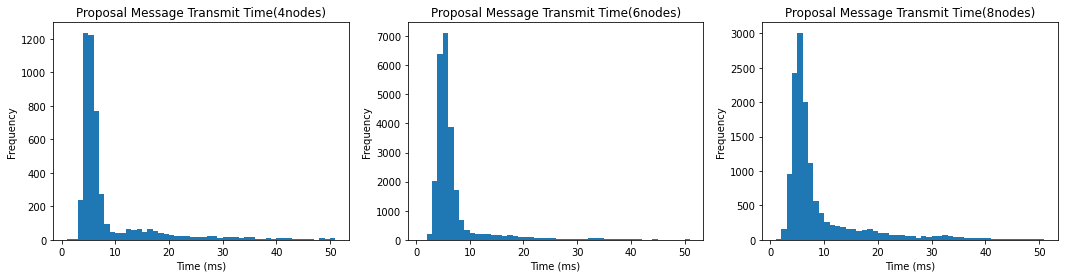

In [8]:
# plot proposal message transmit time
title_labels = ['(4nodes)', '(6nodes)', '(8nodes)']
ts_pro_trans = [ts_pro_4nodes, ts_pro_6nodes, ts_pro_8nodes]
upper = max([np.percentile(ts, 99) for ts in ts_pro_trans])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Proposal Message Transmit Time'
for i in range(len(ts_pro_trans)):
    data = ts_pro_trans[i]
    plot_hist(ts=data, ax=axs[i], upper=upper, bins=50, title=title+title_labels[i])
plt.show()

0.116


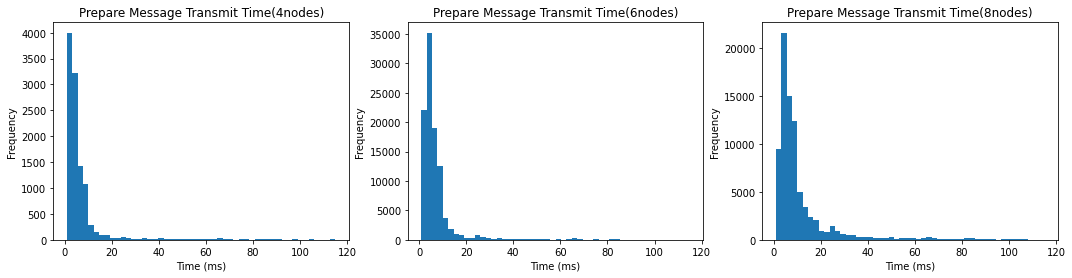

In [9]:
# calculate prepare message transmit time
send_str, receive_str = 'Sending prepare message', 'Received a prepare message'
ts_prep_trans_4nodes = cal_time_delta(send=send_str, receive= receive_str, df=df4)
ts_prep_trans_6nodes = cal_time_delta(send=send_str, receive= receive_str, df=df6)
ts_prep_trans_8nodes = cal_time_delta(send=send_str, receive= receive_str, df=df8)

# plot prepare message transmit time

ts_prep_trans = [ts_prep_trans_4nodes, ts_prep_trans_6nodes, ts_prep_trans_8nodes]
upper = max([np.percentile(ts, 99) for ts in ts_prep_trans])
print(upper)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Prepare Message Transmit Time'
for i in range(len(ts_prep_trans)):
    data = ts_prep_trans[i]
    plot_hist(ts=data, ax=axs[i], upper=upper, bins=50, title=title+title_labels[i])
plt.show()

0.10743999999999869


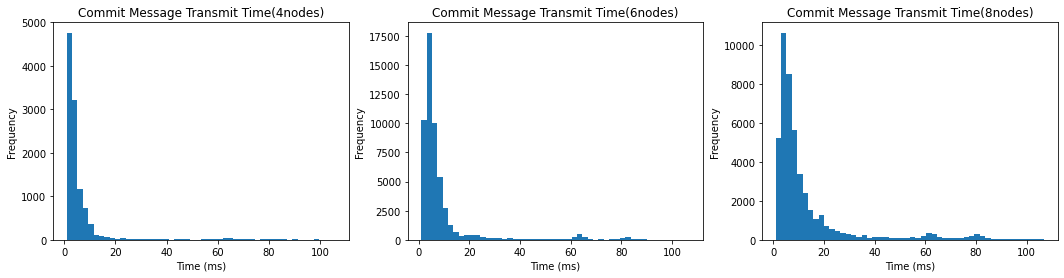

In [10]:
# calculate prepare message transmit time
send_str, receive_str = 'Sending commit message', 'Received a commit message'
ts_commit_trans_4nodes = cal_time_delta(send=send_str, receive= receive_str, df=df4)
ts_commit_trans_6nodes = cal_time_delta(send=send_str, receive= receive_str, df=df6)
ts_commit_trans_8nodes = cal_time_delta(send=send_str, receive= receive_str, df=df8)

# plot prepare message transmit time

ts_commit_trans = [ts_commit_trans_4nodes, ts_commit_trans_6nodes, ts_commit_trans_8nodes]
upper = max([np.percentile(ts, 99) for ts in ts_commit_trans])
print(upper)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Commit Message Transmit Time'
for i in range(len(ts_commit_trans)):
    data = ts_commit_trans[i]
    plot_hist(ts=data, ax=axs[i], upper=upper, bins=50, title=title+title_labels[i])
plt.show()

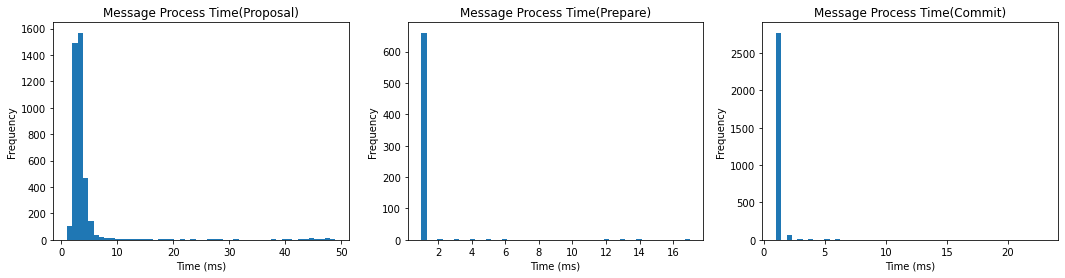

In [89]:
t_process_proposal, t_process_prepare, t_process_commit = cal_process_time(df4)
# plot message process time (4nodes)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Message Process Time'
plot_hist(ts=t_process_proposal, ax=axs[0], upper=50, bins=50, title=title+'(Proposal)')
plot_hist(ts=t_process_prepare, ax=axs[1], upper=50, bins=50, title=title+'(Prepare)')
plot_hist(ts=t_process_commit, ax=axs[2], upper=50, bins=50, title=title+'(Commit)')

plt.show()

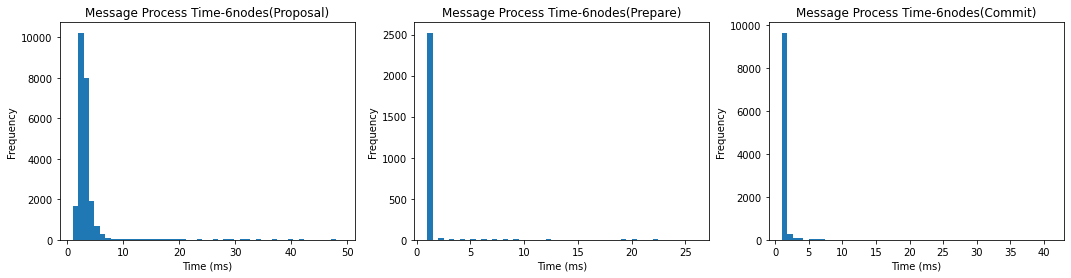

In [92]:
t_process_proposal, t_process_prepare, t_process_commit = cal_process_time(df6)
# plot message process time (6nodes)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Message Process Time-6nodes'
plot_hist(ts=t_process_proposal, ax=axs[0], upper=50, bins=50, title=title+'(Proposal)')
plot_hist(ts=t_process_prepare, ax=axs[1], upper=50, bins=50, title=title+'(Prepare)')
plot_hist(ts=t_process_commit, ax=axs[2], upper=50, bins=50, title=title+'(Commit)')

plt.show()

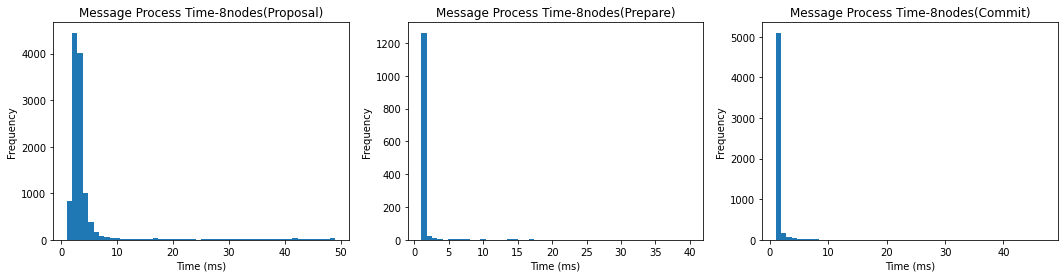

In [93]:
t_process_proposal, t_process_prepare, t_process_commit = cal_process_time(df8)
# plot message process time (8nodes)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = 'Message Process Time-8nodes'
plot_hist(ts=t_process_proposal, ax=axs[0], upper=50, bins=50, title=title+'(Proposal)')
plot_hist(ts=t_process_prepare, ax=axs[1], upper=50, bins=50, title=title+'(Prepare)')
plot_hist(ts=t_process_commit, ax=axs[2], upper=50, bins=50, title=title+'(Commit)')

plt.show()

# Explore Consensus Time

In [5]:
consensus_time5 = cal_consensus_time(df5)

In [17]:
# consensus_time4 = cal_consensus_time(df4)
# consensus_time6 = cal_consensus_time(df6)
# consensus_time8 = cal_consensus_time(df8)

with open('../data/consensus_time4.json') as f:
    consensus_time4 = json.load(f)['consensus_time']
with open('../data/consensus_time6.json') as f:
    consensus_time6 = json.load(f)['consensus_time']
with open('../data/consensus_time8.json') as f:
    consensus_time8 = json.load(f)['consensus_time']

In [15]:
large_time_idx_5 = [idx for idx in range(len(consensus_time5)) if consensus_time5[idx] > 0.2]

In [8]:
len(large_time_idx_5)

73

In [9]:
len(consensus_time5)

1808

In [11]:
np.mean(consensus_time5)

0.0492566371681416

In [7]:
len(large_time_idx_5)/len(consensus_time5)

0.040376106194690266

In [47]:
import json
file_names = ['consensus_time4.json', 'consensus_time6.json', 'consensus_time8.json']
consensus_time = [consensus_time4, consensus_time6, consensus_time8]
for i in range(len(consensus_time)):
    with open(file_names[i], 'w') as f:
        json.dump({'consensus_time': consensus_time[i]}, f, indent=4)

In [18]:
ts4 = remove_outlier_IQR(consensus_time4)
ts6 = remove_outlier_IQR(consensus_time6)
ts8 = remove_outlier_IQR(consensus_time8)
print(len(ts4)/len(consensus_time4))
print(len(ts6)/len(consensus_time6))
print(len(ts8)/len(consensus_time8))

0.7681339119652821
0.9585892609470973
0.9087241553202219


In [12]:
ts5 = remove_outlier_IQR(consensus_time5)
print(len(ts5)/len(consensus_time5))

0.7881637168141593


In [25]:
print('consensus time statistics before removing outliers:')
print('4nodes mean: ', np.round(np.mean(consensus_time4), 3),'   standard deviation: ', np.round(np.std(consensus_time4), 3))
print('6nodes mean: ', np.round(np.mean(consensus_time6), 3),'   standard deviation: ', np.round(np.std(consensus_time6), 3))
print('8nodes mean: ', np.round(np.mean(consensus_time8), 3),'   standard deviation: ', np.round(np.std(consensus_time8), 3))

consensus time statistics before removing outliers:
4nodes mean:  0.138    standard deviation:  3.09
6nodes mean:  0.13    standard deviation:  2.264
8nodes mean:  0.18    standard deviation:  3.574


In [28]:
print('consensus time statistics:')
print('4nodes mean: ', np.round(np.mean(ts4), 3),'   standard deviation: ', np.round(np.std(ts4), 3))
print('6nodes mean: ', np.round(np.mean(ts6), 3),'   standard deviation: ', np.round(np.std(ts6), 3))
print('8nodes mean: ', np.round(np.mean(ts8), 3),'   standard deviation: ', np.round(np.std(ts8), 3))

consensus time statistics:
4nodes mean:  0.019    standard deviation:  0.005
6nodes mean:  0.039    standard deviation:  0.029
8nodes mean:  0.059    standard deviation:  0.037


In [13]:
print('5nodes mean: ', np.round(np.mean(ts5), 3),'   standard deviation: ', np.round(np.std(ts5), 3))

5nodes mean:  0.02    standard deviation:  0.008


In [14]:
df5

,Timestamp,Process,LogLevel,LogSource,Action,Sequence,Round,Node
0,2022-02-07 18:39:27.024000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a proposal message,2,0,1
1,2022-02-07 18:39:27.033000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending prepare message,2,0,1
2,2022-02-07 18:39:27.040000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,1
3,2022-02-07 18:39:27.040000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,2,0,1
4,2022-02-07 18:39:27.046000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,2,0,1
...,...,...,...,...,...,...,...,...
13056,2022-02-07 19:39:39.009000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1808,0,4
13057,2022-02-07 19:39:39.010000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1808,0,4
13058,2022-02-07 19:39:39.010000+00:00,pool-9-thread-1,DEBUG,IbftRound,Sending commit message,1808,0,4
13059,2022-02-07 19:39:39.012000+00:00,pool-9-thread-1,DEBUG,IbftRound,Received a prepare message,1808,0,4


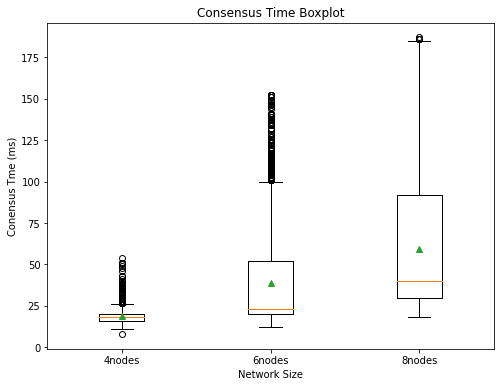

In [198]:
consensus_time = [ts4, ts6, ts8]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
title = "Consensus Time Boxplot"
xlabels = ['4nodes', '6nodes', '8nodes']
positions = np.arange(3) + 1
data_to_plot = []
for i in range(len(consensus_time)):
    data = pd.Series([1000*t for t in consensus_time[i]])
    data_to_plot.append(data)
bp = ax.boxplot(data_to_plot, positions=positions, showmeans=True, labels=xlabels)
ax.set_title(title)
ax.set_xlabel('Network Size')
ax.set_ylabel('Conensus Tme (ms)')
plt.show()

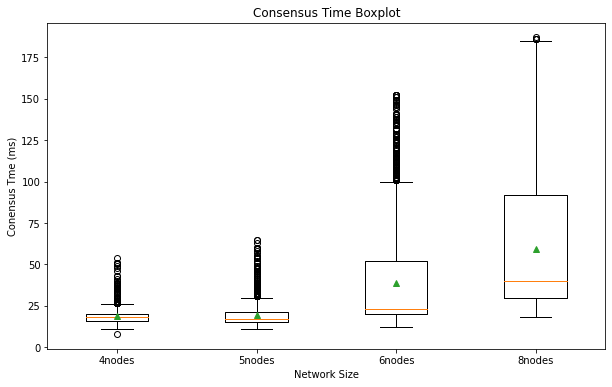

In [19]:
consensus_time = [ts4, ts5, ts6, ts8]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
title = "Consensus Time Boxplot"
xlabels = ['4nodes', '5nodes', '6nodes', '8nodes']
positions = np.arange(4) + 1
data_to_plot = []
for i in range(len(consensus_time)):
    data = pd.Series([1000*t for t in consensus_time[i]])
    data_to_plot.append(data)
bp = ax.boxplot(data_to_plot, positions=positions, showmeans=True, labels=xlabels)
ax.set_title(title)
ax.set_xlabel('Network Size')
ax.set_ylabel('Conensus Tme (ms)')
plt.show()

In [141]:
for k,v in logpaths.items():
    with open(os.path.join(v, 'nodeinfo.json')) as f:
        data = json.load(f)
    df = pd.DataFrame(data=data['nodeinfo'], columns=['NodeName', 'IP', 'NodeAddress', 'IsValidator', 'InstanceID', 'HostID'])
    print(k)
    print(df[['NodeName', 'HostID']])
    print(len(df.HostID.unique()))

4nodes
  NodeName                                             HostID
0   besu-2  b63081ee267952efbac4c2c0f0127e067bd4a385bdc810...
1   besu-4  24c113f9c84e4a4f346e00fefefb5510f40736a41ce903...
2   besu-1  249eb13a931a5ffac2ef3b3c9d5188a2e87a0772cf068a...
3   besu-3  17497a9a09a63cd570b1d839818b807207919152f9438e...
4
6nodes
  NodeName                                             HostID
0   besu-4  17497a9a09a63cd570b1d839818b807207919152f9438e...
1   besu-2  24c113f9c84e4a4f346e00fefefb5510f40736a41ce903...
2   besu-1  249eb13a931a5ffac2ef3b3c9d5188a2e87a0772cf068a...
3   besu-6  12e678d36d6dc54feee7fb00fe48678bab6fd26a76a20d...
4   besu-3  b63081ee267952efbac4c2c0f0127e067bd4a385bdc810...
5   besu-5  5bc3c72bf1b42515cb454e42d4bc94b7b7acd3f12519d0...
6
8nodes
  NodeName                                             HostID
0   besu-6  17497a9a09a63cd570b1d839818b807207919152f9438e...
1   besu-8  b63081ee267952efbac4c2c0f0127e067bd4a385bdc810...
2   besu-1  5bc3c72bf1b42515cb454e42d4bc94b7b

# distfit Consensus Message Transmit Time

In [14]:
trans_ts = [[ts_pro_4nodes, ts_pro_6nodes, ts_pro_8nodes],
            [ts_prep_trans_4nodes, ts_prep_trans_6nodes, ts_prep_trans_8nodes],
            [ts_commit_trans_4nodes, ts_commit_trans_6nodes, ts_commit_trans_8nodes]]
trans_ts_IQR = []
for i in range(len(trans_ts)):
    ts_trans = []
    for j in range(len(trans_ts[0])):
        ts_orig = trans_ts[i][j]
        ts = remove_outlier_IQR(trans_ts[i][j])
        ts_trans.append(ts)
        print(len(ts)/len(ts_orig))
    trans_ts_IQR.append(ts_trans)

0.8231024471173787
0.8887472615016929
0.865826269651525
0.8911464637731281
0.8942663408794292
0.8864718862668965
0.9060342508742042
0.8893027608797379
0.8738290835378214


[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.1171269] [loc=7.998 scale=7.526]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.1123758] [loc=1.000 scale=6.998]
[distfit] >[pareto    ] [0.11 sec] [RSS: 0.1933009] [loc=-0.707 scale=1.707]
[distfit] >[dweibull  ] [0.40 sec] [RSS: 0.0579715] [loc=5.000 scale=4.964]
[distfit] >[t         ] [0.11 sec] [RSS: 0.0108624] [loc=4.901 scale=0.955]
[distfit] >[genextreme] [0.35 sec] [RSS: 0.0336645] [loc=4.890 scale=2.005]
[distfit] >[gamma     ] [0.14 sec] [RSS: 0.2845476] [loc=1.000 scale=3.351]
[distfit] >[lognorm   ] [0.18 sec] [RSS: 0.0566567] [loc=0.955 scale=5.172]
[distfit] >[beta      ] [0.37 sec] [RSS: 0.0831235] [loc=0.997 scale=26245464961.469]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.1520943] [loc=1.000 scale=49.000]
[distfit] >[loggamma  ] [0.62 sec] [RSS: 0.1188536] [loc=-2535.875 scale=338.762]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >transfor

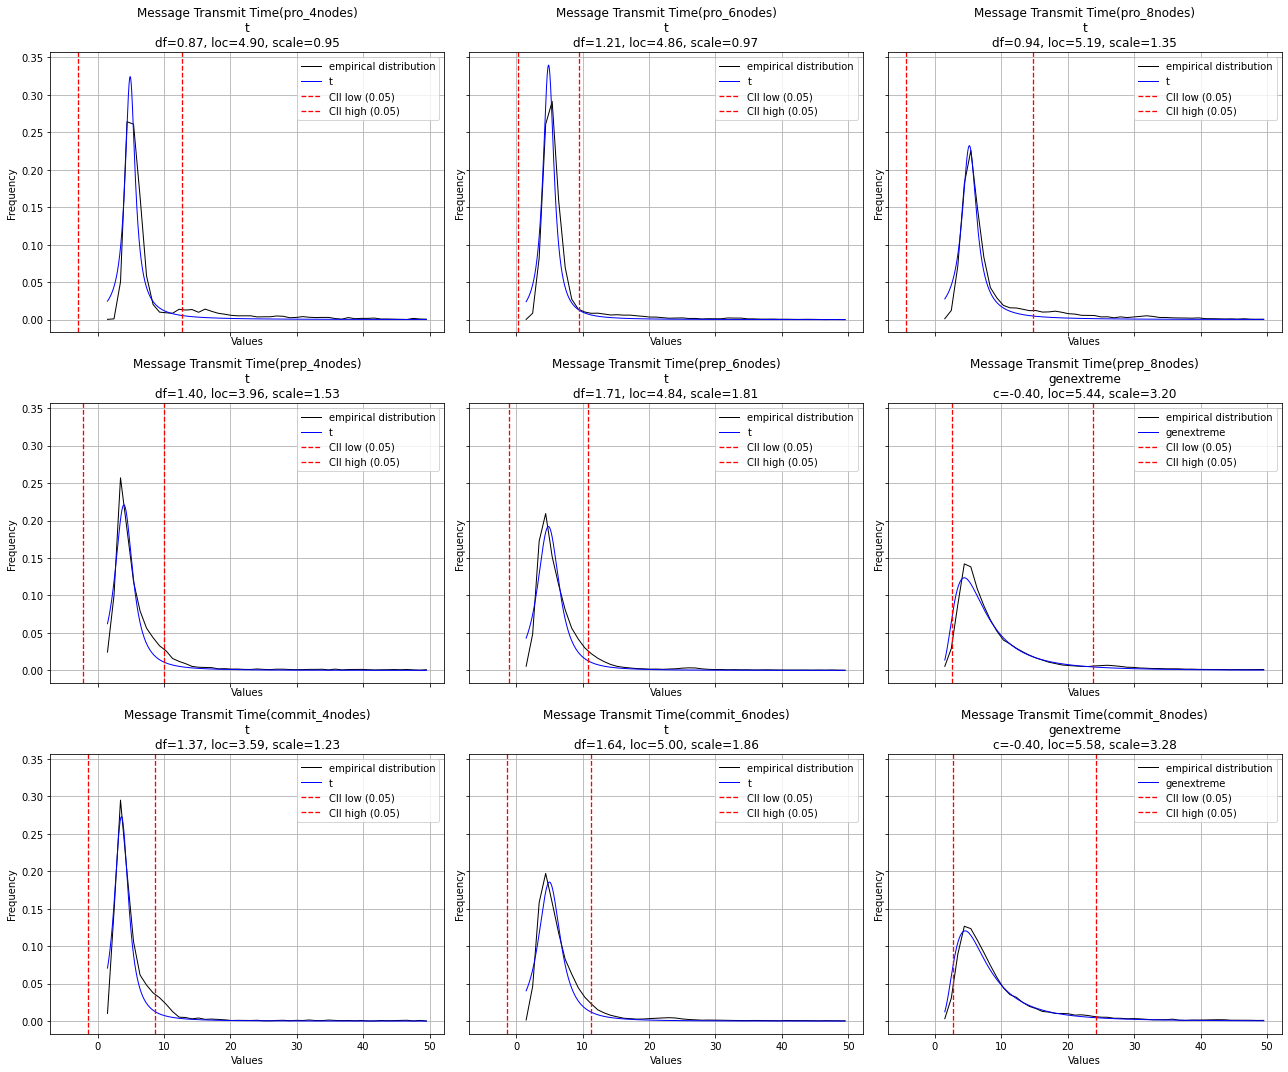

In [221]:
from distfit import distfit
import matplotlib.pyplot as plt
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 15), sharex=True, sharey=True)
title = "Message Transmit Time"
labels = [['pro_4nodes', 'pro_6nodes', 'pro_8nodes'],
            ['prep_4nodes', 'prep_6nodes', 'prep_8nodes'],
            ['commit_4nodes', 'commit_6nodes', 'commit_8nodes']]
dists = []
for row in range(rows):
    dists_stage = []
    for col in range(cols):
        dist = distfit()
        data = pd.Series([1000*t for t in trans_ts[row][col] if t > 0 and 1000*t <= 50])
        dist.fit_transform(data)
        dists_stage.append(dist)
        dist.plot(title=title+'('+labels[row][col]+')', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[row][col], verbose=3)
    dists.append(dists_stage)
plt.tight_layout()
plt.show()

[distfit] >fit..
[distfit] >transform..
[distfit] >[t] [0.25 sec] [RSS: 0.0108624] [loc=4.901 scale=0.955]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >transform..
[distfit] >[t] [0.34 sec] [RSS: 0.0087208] [loc=4.865 scale=0.970]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >transform..
[distfit] >[t] [0.16 sec] [RSS: 0.0037079] [loc=5.191 scale=1.354]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >transform..
[distfit] >[t] [0.19 sec] [RSS: 0.0070774] [loc=3.960 scale=1.526]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >transform..
[distfit] >[t] [1.63 sec] [RSS: 0.0066531] [loc=4.842 scale=1.806]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >transform..
[distfit] >[t] [0.99 sec] [RSS: 0.0058605] [loc=6.152 scale=2.755]
[distfit

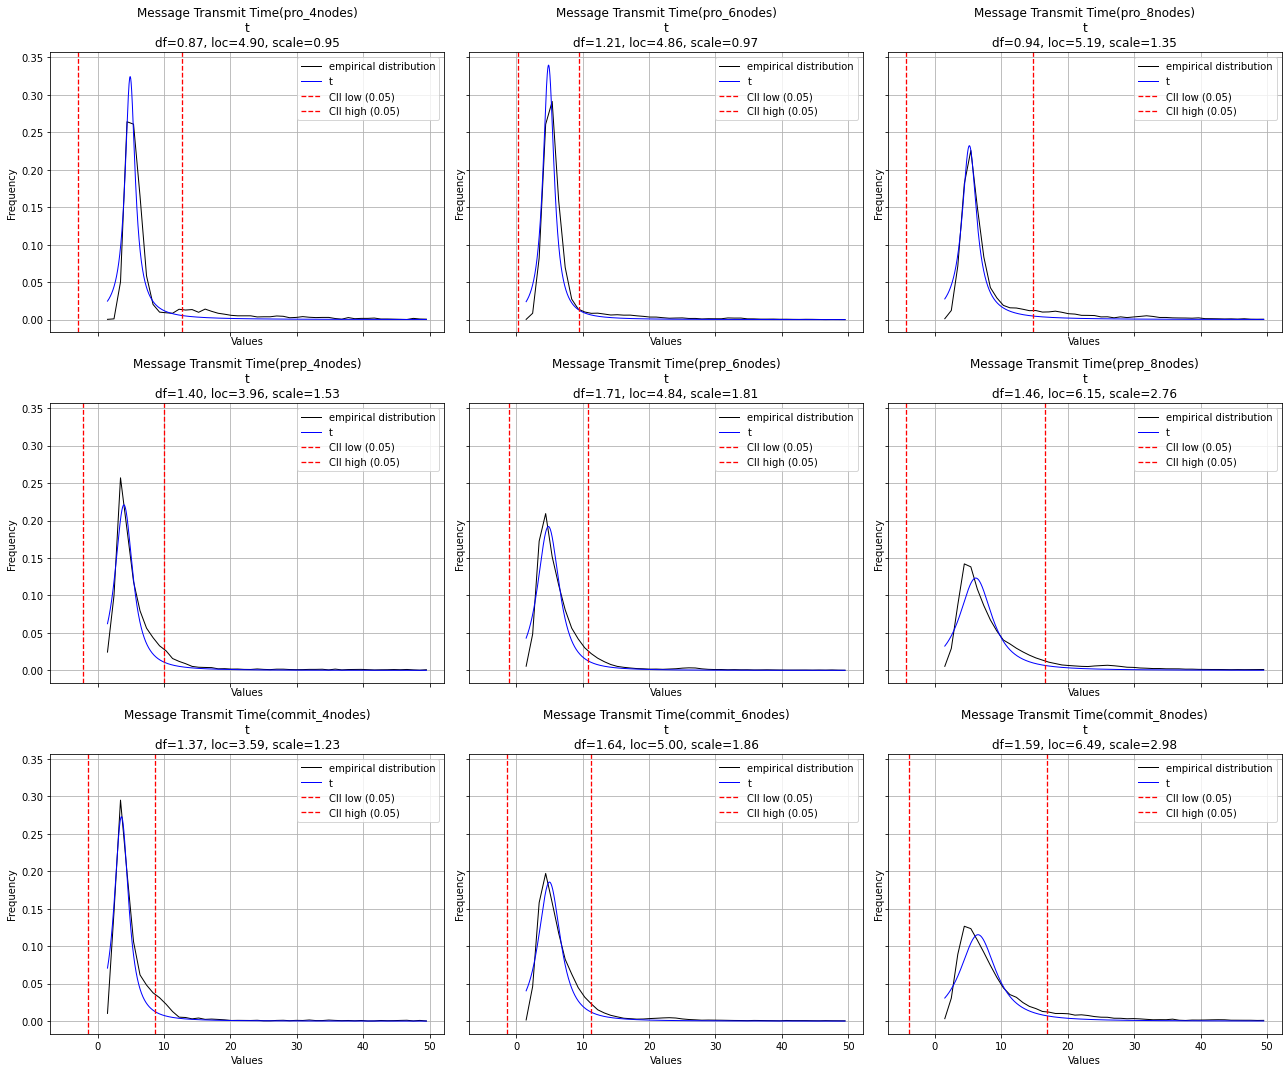

In [15]:
from distfit import distfit
import matplotlib.pyplot as plt
rows, cols = 3, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 15), sharex=True, sharey=True)
title = "Message Transmit Time"
labels = [['pro_4nodes', 'pro_6nodes', 'pro_8nodes'],
            ['prep_4nodes', 'prep_6nodes', 'prep_8nodes'],
            ['commit_4nodes', 'commit_6nodes', 'commit_8nodes']]
dists = []
for row in range(rows):
    dists_stage = []
    for col in range(cols):
        dist = distfit(distr='t')
        data = pd.Series([1000*t for t in trans_ts[row][col] if t > 0 and 1000*t <= 50])
        dist.fit_transform(data)
        dists_stage.append(dist)
        dist.plot(title=title+'('+labels[row][col]+')', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[row][col], verbose=3)
    dists.append(dists_stage)
plt.tight_layout()
plt.show()

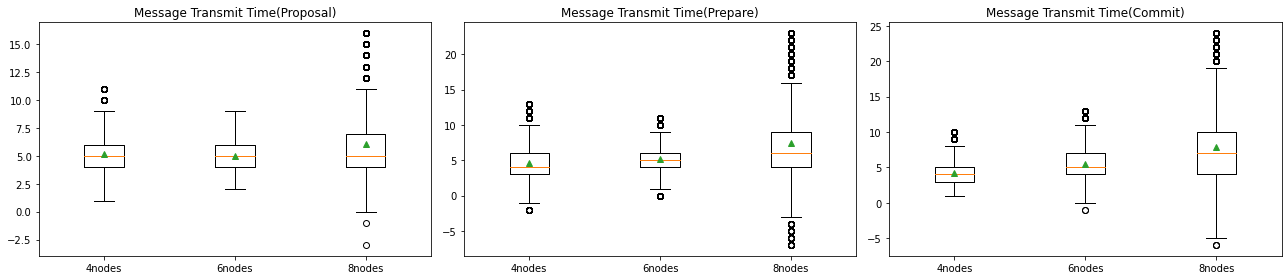

In [168]:
# box plot after removing outliers using IQR
rows, cols = 1, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 4), sharex=False, sharey=False)
title = "Message Transmit Time"
title_labels = ['Proposal', 'Prepare', 'Commit']
xlabels = ['4nodes', '6nodes', '8nodes']
positions = np.arange(3) + 1
for col in range(cols):
    data_to_plot = []
    for ts in trans_ts_IQR[col]:
        data = pd.Series([1000*t for t in ts])
        data_to_plot.append(data)
    bp = axes[col].boxplot(data_to_plot, positions=positions, showmeans=True, labels=xlabels)
    axes[col].set_title(title+'({})'.format(title_labels[col]))
plt.tight_layout()
plt.show()

# distfit Fitting Consensus Time

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.01 sec] [RSS: 0.0123432] [loc=34.262 scale=37.844]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0088337] [loc=8.000 scale=26.262]
[distfit] >[pareto    ] [0.09 sec] [RSS: 0.0126410] [loc=-0.055 scale=8.055]
[distfit] >[dweibull  ] [0.32 sec] [RSS: 0.0072689] [loc=19.000 scale=32.492]
[distfit] >[t         ] [0.12 sec] [RSS: 0.0010434] [loc=18.033 scale=2.302]
[distfit] >[genextreme] [0.55 sec] [RSS: 0.0029167] [loc=18.136 scale=6.580]
[distfit] >[gamma     ] [0.18 sec] [RSS: 0.0088974] [loc=8.000 scale=26.880]
[distfit] >[lognorm   ] [0.06 sec] [RSS: 0.0055478] [loc=7.919 scale=14.757]
[distfit] >[beta      ] [0.22 sec] [RSS: 0.0089349] [loc=8.000 scale=2211.496]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0137812] [loc=8.000 scale=191.000]
[distfit] >[loggamma  ] [0.15 sec] [RSS: 0.0124144] [loc=-12778.618 scale=1704.123]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distfit] >tra

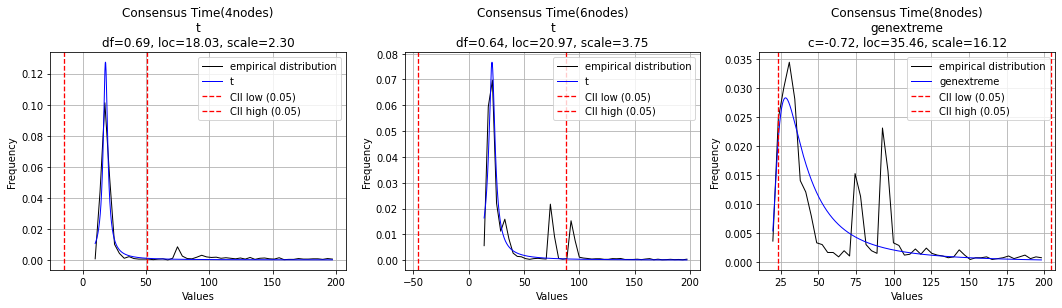

In [118]:
from distfit import distfit
import matplotlib.pyplot as plt

consensus_time = [consensus_time4, consensus_time6, consensus_time8]
rows, cols = 1, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 4))
title = "Consensus Time"
title_labels = ['4nodes', '6nodes', '8nodes']
for col in range(cols):
    dist = distfit()
    data = pd.Series([1000*t for t in consensus_time[col] if t > 0 and 1000*t <= 200])
    dist.fit_transform(data)
    dist.plot(title=title+'({})'.format(title_labels[col]), figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[col], verbose=3)
plt.show()

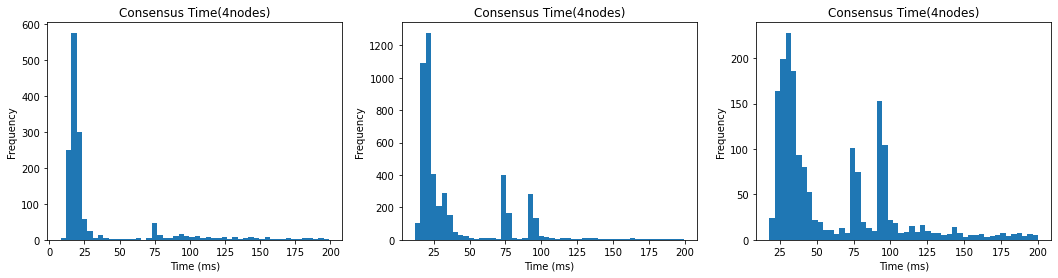

In [64]:
consensus_time = [consensus_time4, consensus_time6, consensus_time8]
rows, cols = 1, 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 4))
title = "Consensus Time"
title_labels = ['4nodes', '6nodes', '8nodes']
for col in range(cols):
    data = pd.Series([t for t in consensus_time[col] if t > 0 and 1000*t <= 200])
    plot_hist(ts=data, ax=axes[col], bins=50, title=title+'(4nodes)')
plt.show()

In [30]:
# Load Compute Canada data
log_path_4nodes = '../data/logs-20220125-182415-4nodes'
df_4nodes = load_log(logpath=log_path_4nodes)
log_path_8nodes = '../data/logs-20220125-204841-8nodes'
df_8nodes = load_log(logpath=log_path_8nodes)
log_path_6nodes = '../data/logs-20220125-221756-6nodes'
df_6nodes = load_log(logpath=log_path_6nodes)

In [33]:
consensus_time_4nodes = cal_consensus_time(df_4nodes)
consensus_time_6nodes = cal_consensus_time(df_6nodes)
consensus_time_8nodes = cal_consensus_time(df_8nodes)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.15 sec] [RSS: 0.0074829] [loc=20.839 scale=24.453]
[distfit] >[expon     ] [0.01 sec] [RSS: 0.0040672] [loc=4.000 scale=16.839]
[distfit] >[pareto    ] [0.37 sec] [RSS: 0.0087277] [loc=-0.015 scale=4.015]
[distfit] >[dweibull  ] [1.50 sec] [RSS: 0.0032124] [loc=10.000 scale=7.995]
[distfit] >[t         ] [0.93 sec] [RSS: 0.0039490] [loc=12.746 scale=6.292]
[distfit] >[genextreme] [1.23 sec] [RSS: 0.0014908] [loc=10.862 scale=5.414]
[distfit] >[gamma     ] [3.09 sec] [RSS: 0.0106623] [loc=4.000 scale=4.506]
[distfit] >[lognorm   ] [0.68 sec] [RSS: 0.0024479] [loc=3.907 scale=10.205]
[distfit] >[beta      ] [9.04 sec] [RSS: 0.0037253] [loc=3.998 scale=21654111348519.258]
[distfit] >[uniform   ] [0.01 sec] [RSS: 0.0110210] [loc=4.000 scale=195.000]
[distfit] >[loggamma  ] [4.35 sec] [RSS: 0.0077064] [loc=-11101.972 scale=1400.389]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
[distfit] >fit..
[distf

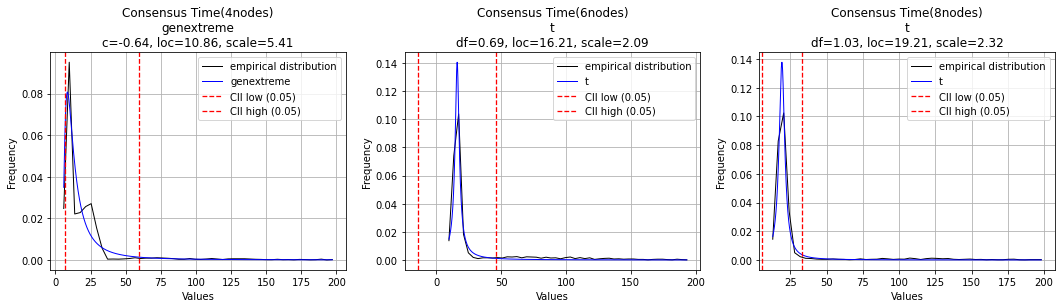

In [34]:
from distfit import distfit
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
title = "Consensus Time"

dist1 = distfit()
data1 = pd.Series([1000*t for t in consensus_time_4nodes if t > 0 and 1000*t <= 200])
dist1.fit_transform(data1)
dist1.plot(title=title+'(4nodes)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[0], verbose=3)

dist2 = distfit()
data2 = pd.Series([1000*t for t in consensus_time_6nodes if t > 0 and 1000*t <= 200])
dist2.fit_transform(data2)
dist2.plot(title=title+'(6nodes)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[1], verbose=3)

dist3 = distfit()
data3 = pd.Series([1000*t for t in consensus_time_8nodes if t > 0 and 1000*t <= 200])
dist3.fit_transform(data3)
dist3.plot(title=title+'(8nodes)', figsize=(5, 4), xlim=None, ylim=None, fig=fig, ax=axes[2], verbose=3)

plt.show()

In [5]:
np.mean(consensus_time_4nodes)

0.03821391138637447

In [12]:
np.mean(consensus_time_6nodes)

0.0392463389121339

In [6]:
np.mean(consensus_time_8nodes)

0.061741736694677876

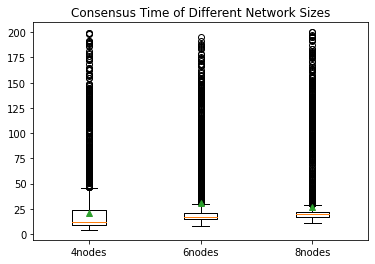

In [35]:
import matplotlib.pyplot as plt
import numpy as np

data1 = pd.Series([1000*t for t in consensus_time_4nodes if t > 0 and 1000*t <= 200])
data2 = pd.Series([1000*t for t in consensus_time_6nodes if t > 0 and 1000*t <= 200])
data3 = pd.Series([1000*t for t in consensus_time_8nodes if t > 0 and 1000*t <= 200])

data_to_plot = [data1, data2, data3]
positions = np.arange(3) + 1

fig, ax = plt.subplots(figsize=(6,4))

labels = ['4nodes', '6nodes', '8nodes']
bp = ax.boxplot(data_to_plot, positions=positions, showmeans=True, labels=labels)
ax.set_title("Consensus Time of Different Network Sizes")

plt.show()

In [21]:
np.mean(data1)

20.83884099616858

In [22]:
np.mean(data2)

28.98367561874671

In [23]:
np.mean(data3)

23.501005458201668